In [1]:
import os
import glob
import argparse
import pandas as pd
from collections import defaultdict
def rec_dd():
    return defaultdict(rec_dd)

## 數據位置

In [2]:
CONCEPT_CSV_PATH = "statistics/ddf--concepts.csv"
TAG_CSV_PATH = "statistics/ddf--entities--tag.csv"

## 找出有哪些指標有台灣數據

In [3]:
num_available, total = 0, 0
indicator_twn_tuples = list()  # format of a single tuple: (indicator_name, #twn rows, earliest available year)
concept_metadata = rec_dd()  # {top_tag: second_layer_tag: {concept_name, num_year_available, earliest_year} }

# read in concept/tag DDF files for easy-understanding indicator names and build concept structure
df_c = pd.read_csv(CONCEPT_CSV_PATH)
df_t = pd.read_csv(TAG_CSV_PATH)
df_metadata = pd.merge(df_c, df_t, how='left', left_on='tags', right_on='tag')

# parse all ddf files provided by GapMinder and find how many of them with Taiwan statistics
for f_path in glob.glob(os.path.join('statistics', '*datapoints*.csv')):
    total += 1
    df = pd.read_csv(f_path)
    if 'twn' in df.geo.unique():
        num_available += 1
        indicator = f_path.replace('statistics/ddf--datapoints--', '').replace('--by--geo--time.csv', '')
        df_tw = df[df.geo == 'twn']
        num_years, earliest_year = len(df_tw), min(df_tw['time'])
        indicator_twn_tuples.append((indicator, num_years, earliest_year))
        
        # generate concept structure
        ancestors = list()
        row_values = df_metadata[df_metadata['concept'] == indicator].values[0]
        name_catalog, parent, ancestor = (row_values[i] for i in [9, 17, 18])
        if type(parent) is str:
            ancestors.append(parent)

        # get ancestors recursively
        while type(ancestor) is str:
            tag_row_values = df_t[df_t['tag'] == ancestor].values[0]
            ancestors.append(tag_row_values[1])
            ancestor = tag_row_values[2]
        ancestors = ancestors[::-1]
            
        # save result into concept dict
        d = concept_metadata
        for tag in ancestors:
            d = d[tag]
        d[indicator] = {
            'name_catalog': name_catalog,
            'raw_name': indicator,
            'num_years': num_years,
            'earliest_year': earliest_year
        }    

print(f"Total number of indicators: {total}, #indicators with Taiwan data: {num_available}")
print("{:.1f}% datapoints have Taiwan statistics".format(num_available / float(total) * 100))


Total number of indicators: 535, #indicators with Taiwan data: 207
38.7% datapoints have Taiwan statistics


## 依照指標的大、中分類列出各個指標 meta-data

In [4]:
dic = {}
for top_tag, d in concept_metadata.items():
    num_indicators = 0
    if type(d) is dict:
        print(d['name_catalog'], d['earliest_year'], '(有 {} 年資料，最早年份：{})'.format(d['num_years'], d['earliest_year']))
        num_indicators += 1
    else:
        print(top_tag)
        
        for secondary_tag, dd in d.items():
            print('\t', secondary_tag)
            for _, info in dd.items():
                if type(info) is dict:
                    print('\t\t', info['name_catalog'], '(有 {} 年資料，最早年份：{})'.format(info['num_years'], info['earliest_year']))
                else:
                    print('\t\t', info)
                
                num_indicators += 1
    print(top_tag, num_indicators)
    dic[top_tag] = num_indicators

工作
	 失業
		 Females aged 15+ (有 40 年資料，最早年份：1978)
		 Aged 55+ (有 40 年資料，最早年份：1978)
		 Males aged 15+ (有 40 年資料，最早年份：1978)
		 Aged 55-64 (有 40 年資料，最早年份：1978)
		 Females aged 55-64 (有 40 年資料，最早年份：1978)
		 Males aged 55-64 (有 40 年資料，最早年份：1978)
		 Females aged 25-54 (有 40 年資料，最早年份：1978)
		 Aged 25-54 (有 40 年資料，最早年份：1978)
		 Males aged 25-54 (有 40 年資料，最早年份：1978)
		 Males aged 15-24 (有 40 年資料，最早年份：1978)
		 Males aged 55+ (有 40 年資料，最早年份：1978)
		 Aged 15+ (有 40 年資料，最早年份：1978)
		 Aged 15-24 (有 40 年資料，最早年份：1978)
		 Females aged 15-24 (有 40 年資料，最早年份：1978)
		 Females aged 65+ (有 40 年資料，最早年份：1978)
	 勞動力參與
		 Males aged 25-54 (有 41 年資料，最早年份：1990)
		 Aged 25-54 (有 41 年資料，最早年份：1990)
		 Males aged 65+ (有 41 年資料，最早年份：1990)
		 Females aged 25-54 (有 41 年資料，最早年份：1990)
		 Aged 65+ (有 41 年資料，最早年份：1990)
		 Females aged 65+ (有 41 年資料，最早年份：1990)
		 Aged 15-64 (有 41 年資料，最早年份：1990)
		 Males aged 15-64 (有 41 年資料，最早年份：1990)
		 Males aged 15+ (有 41 年資料，最早年份：1990)
		 Aged 15+ (有 41 年資料，最早年份：1990)
		 Females aged 15-64

In [5]:
d = {k: v for k, v in dic.items() if 'c' not in k}
d

{'工作': 48,
 '進階用途': 38,
 '經濟': 9,
 '健康': 63,
 '人口': 10,
 '能源': 8,
 '教育': 18,
 '環境': 14,
 '社會': 12,
 '公共建設': 1}

In [6]:
df = pd.DataFrame.from_dict(d, orient='index')
df = df.reset_index()
df.columns = ['tag', 'num_indicators']
df = df.sort_values('num_indicators', ascending=True)
df

,tag,num_indicators
9,公共建設,1
5,能源,8
2,經濟,9
4,人口,10
8,社會,12
7,環境,14
6,教育,18
1,進階用途,38
0,工作,48
3,健康,63


## 統計各個分類有多少指標包含台灣數據並畫圖
生成後放到 blog 資料夾

In [7]:
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('fivethirtyeight')

In [8]:
plt.rcParams['font.sans-serif'] = ['SimHei']
plt.rcParams['axes.unicode_minus'] = False

In [9]:
!ls ../../blog/leemengtaiwan.github.io/content/images/gapminder/gapminder-indicators-with-twn.svg

../../blog/leemengtaiwan.github.io/content/images/gapminder/gapminder-indicators-with-twn.svg


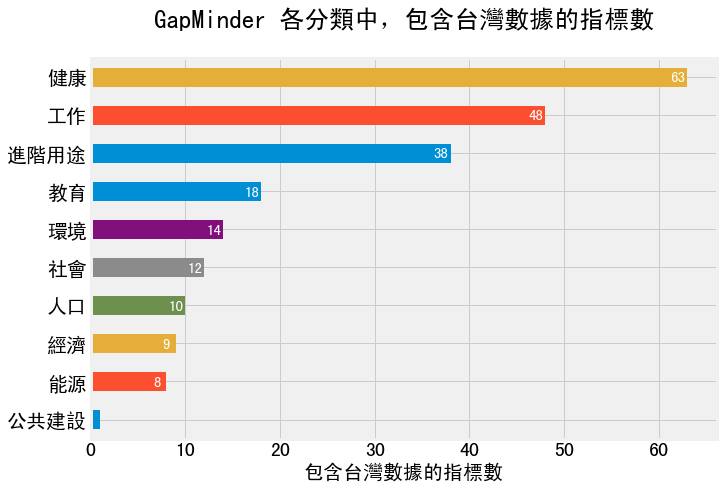

In [10]:
num_tags = len(df.tag)
ax = df.plot('tag', 'num_indicators', kind='barh', figsize=(10, 7))
ax.legend().set_visible(False)
plt.title('GapMinder 各分類中，包含台灣數據的指標數\n', fontsize=25)
plt.xlabel('包含台灣數據的指標數', fontsize=20)
plt.ylabel('', fontsize=20) 
plt.yticks(range(num_tags), df.tag, fontsize=20)
plt.xticks(fontsize=20)

rects = ax.get_children()[:num_tags]
for rect in rects:
    width = rect.get_width()
    if width < 5: continue
    plt.gca().text(width - 1, rect.get_y() + 0.08,
                '{}'.format(int(width)) , fontsize=15,
                ha='center', va='bottom', color='white')

plt.savefig('../../blog/leemengtaiwan.github.io/content/images/gapminder/gapminder-indicators-with-twn.svg', bbox_inches='tight')

## 更新泡泡圖選單
- 為選單裡頭每個分類加上「台灣指標數」，並為每個指標加上「最早年份」。
- 泡泡圖選單由 `ddf--entities--tag.csv` 定義

In [11]:
df_t

,tag,name,parent
0,achievement,Achievement,education
1,advanced,進階用途,NaN
2,advanced_debt_trade,Advanced debt & trade,advanced
3,aid_given,援助（提供）,economy
4,aid_received,援助（獲得）,economy
5,alternative_child_mortality_data,Alternative child mortality data,advanced
6,alternative_demography_indicators,Alternative demography indicators,advanced
7,alternative_energy,Alternative energy,advanced
8,alternative_gdp_data,Alternative GDP data,advanced
9,alternative_health_data,Alternative health data,advanced


## Translation

In [ ]:
CSV_PATH = "statistics/ddf--concepts.csv"

In [ ]:
df = pd.read_csv(CSV_PATH)
df.head()

In [ ]:
df.loc[df.concept == 'income_groups']

In [ ]:
df.loc[df.concept == 'income_groups', 'name'] = '所得區間'

In [ ]:
df.to_csv(CSV_PATH, index=False)

## Find file structure for concepts with Taiwan data

In [10]:
CONCEPT_CSV_PATH = "statistics/ddf--concepts.csv"
TAG_CSV_PATH = "statistics/ddf--entities--tag.csv"

In [ ]:
df_c = pd.read_csv(CONCEPT_CSV_PATH)
df_c.head()

In [ ]:
df_c[df_c['concept'] == 'aged_15_24_unemployment_rate_percent']

In [ ]:
df_t = pd.read_csv(TAG_CSV_PATH)
df_t.head(3)

In [ ]:
df = pd.merge(df_c, df_t, how='left', left_on='tags', right_on='tag')
df.head()

In [ ]:
df[df['concept'] == 'aged_15_24_unemployment_rate_percent']

In [ ]:
df_t[df_t['tag'] == 'work']

In [ ]:
indicators = ['aged_15_24_unemployment_rate_percent']
for idr in indicators:
    ancestors = list()
    
    row_values = df[df['concept'] == idr].values[0]
    name_catalog, parent, ancestor = (row_values[i] for i in [9, 17, 18])
    ancestors.append(parent)
    
    # get ancestors recursively
    while type(ancestor) is str:
        tag_row_values = df_t[df_t['tag'] == ancestor].values[0]
        ancestors.append(tag_row_values[1])
        ancestor = tag_row_values[2]

    # build concept structure
    ancestors.insert(0, name_catalog)
    print('/'.join(ancestors[::-1]))
    


## ggplot2 ploting 
環境是從 `rpy2` 的 Docker image 裡頭執行的

In [42]:
import rpy2

In [43]:
%load_ext rpy2.ipython

The rpy2.ipython extension is already loaded. To reload it, use:
  %reload_ext rpy2.ipython


In [46]:
%R require(ggplot2)
%R -i df

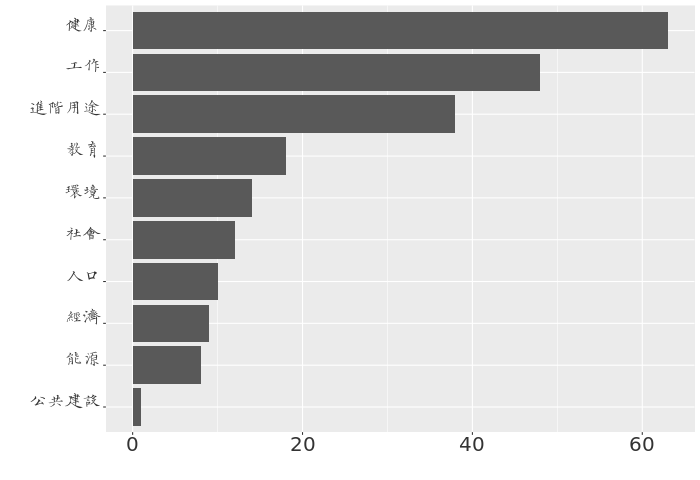

In [74]:
%%R -w 700

df$tag <- factor(df$tag, levels = df$tag[order(df$num_indicators)])

ggplot(df, aes(x = tag, y = num_indicators), family = "DFPLiSong") + 
    geom_bar(stat = 'identity') +
    labs(x = '', y = '') +
    coord_flip() + 
    theme(
        axis.text.x = element_text(colour="grey20",size=20,angle=0,hjust=.5,vjust=.5,face="plain"),
        axis.text.y = element_text(colour="grey20",size=20,angle=0,hjust=1,vjust=0,face="plain"),  
        axis.title.x = element_text(colour="grey20",size=24,angle=0,hjust=.5,vjust=0,face="plain"),
        axis.title.y = element_text(colour="grey20",size=24,angle=90,hjust=.5,vjust=.5,face="plain"))

